In [1]:
%load_ext autoreload
%autoreload 2

In [60]:
import pandas as pd
import numpy as np
import itertools
import mplfinance as mpf
import re
import math
from math import floor
import sys
import os
import datetime as dt
import seaborn as sns

sys.path.append('../')

from functions import *
from functions.preprocessing import *
from functions.swing_points import *
from functions.fvg import *

quandl_api_key = '_umNYuQHdkCgs9Rcm4Fv'

In [3]:
df = pd.read_csv('../data/GLBX-20231023-KQS5VQRSDH/glbx-mdp3-20170521-20231022.ohlcv-1m.csv')

In [4]:
df_es = df[df.symbol.str.startswith('ES')].drop(columns=['rtype', 'publisher_id', 'instrument_id', 'symbol'])
df_es['ts_event'] = pd.to_datetime(df_es.ts_event).dt.tz_convert('America/New_York')
df_es['datetime'] = df_es.ts_event
df_es.drop(columns='ts_event', inplace=True)
df_es.set_index('datetime', inplace=True)

# remove duplicated candles by keeping only the ones with the higher volume (those seem to be the right ones)
df_es = df_es.sort_values(by=['datetime', 'volume'], ascending=[True, False])
df_es = df_es[~df_es.index.duplicated(keep='first')]
df_es = df_es[df_es.open >= 2000]

In [5]:
df_current = pd.read_csv('/Users/kush/Downloads/CME_MINI_ES1!, 1_8dcab.csv')
df_current.set_index(pd.to_datetime(df_current.time, utc=True), inplace=True)
df_current.index = df_current.index.tz_convert('America/New_York')
df_current = df_current[['open', 'high', 'low', 'close']]

# current_date_str = df_current.index.max().strftime('%Y-%m-%d')  # Get the last date in the dataframe as a string
# df_current = df_current[current_date_str:].between_time('0000', '0929')

In [41]:
from dtaidistance import dtw
import numpy as np

# Assuming 'df' is your DataFrame with OHLC data and a DateTimeIndex
df = df_es[['open', 'high', 'low', 'close']]

# Function to extract and normalize the overnight session
def get_normalized_overnight(df, date):
    session_df = df.loc[date].between_time('00:00', '09:29').close
    return (session_df - session_df.mean()) / session_df.std()


current_date_str = (df_current.index.max()  - dt.timedelta(days=1)).strftime('%Y-%m-%d')  # Get the last date in the dataframe as a string
current_overnight = get_normalized_overnight(df_current, current_date_str).values.flatten()

# Prepare the series list (only weekdays)
dates = np.unique(df.index[df.index.weekday < 5].date)
print('getting past overnight seesions...')
series_list = [get_normalized_overnight(df, date.strftime('%Y-%m-%d')).values.flatten() for date in dates]

# Calculate the distance matrix, handling variable-length series
print('calculating distances...')

distances = {}
for idx, date in enumerate(dates):
    try:
        distance = dtw.distance_fast(current_overnight, series_list[idx])
        distances[date] = distance
    except:
        print(date)
    
# Find the top 3 similar days
similar_days = sorted(distances, key=distances.get)[:3]

# Print the results
print("Top 3 similar days based on DTW distance:")
for day in similar_days:
    print(day, distances[day])

getting past overnight seesions...
calculating distances...
2017-12-25
2018-01-01
2018-12-25
2019-01-01
2019-12-25
2020-01-01
2022-12-26
2023-01-02
Top 3 similar days based on DTW distance:
2023-04-03 5.270332725365342
2020-03-19 5.29216395697819
2021-08-25 5.386226425419222


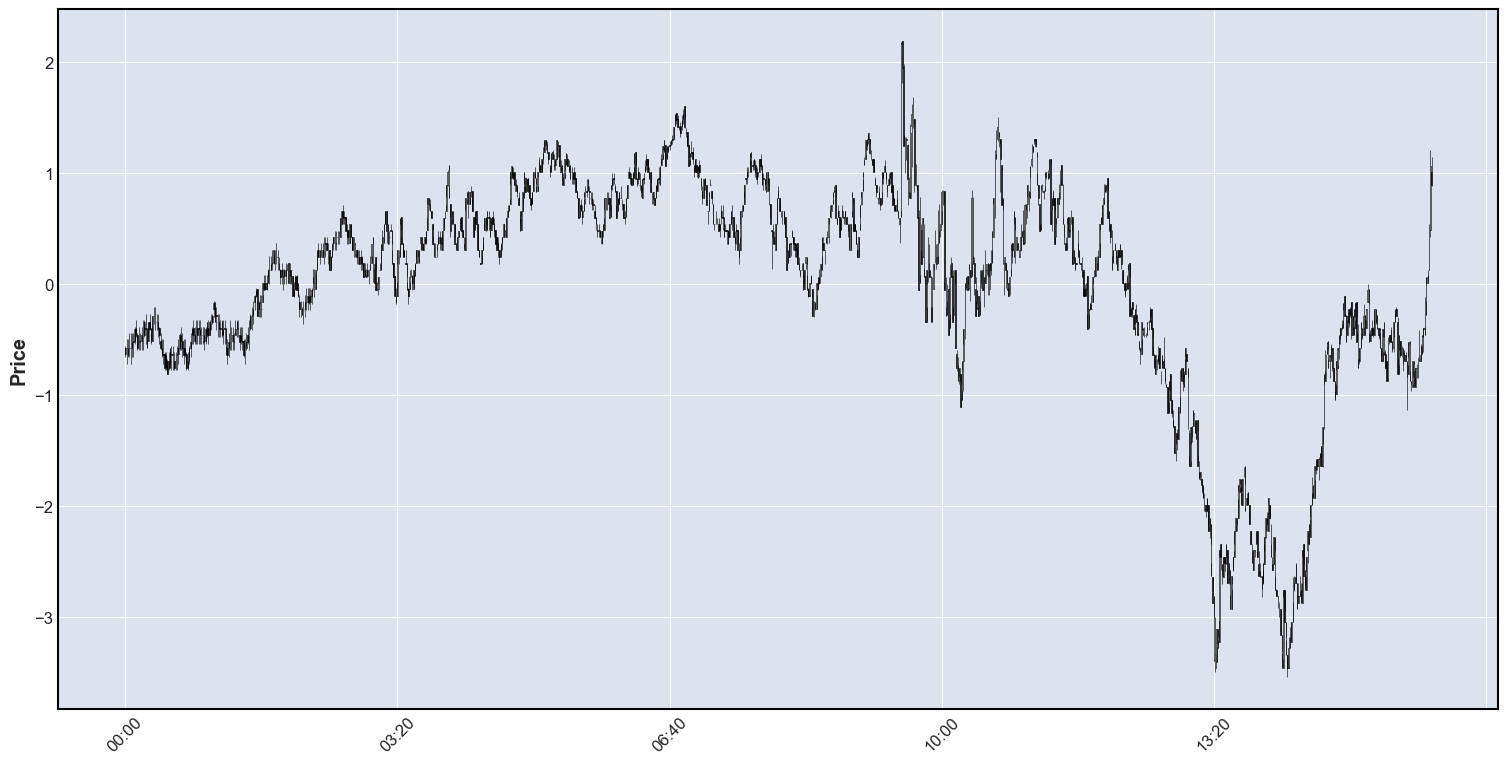

In [39]:
import mplfinance as mpf

session_df = df_current.loc[current_date_str].between_time('0000', '1600')
today_normalized = (session_df - session_df.mean()) / session_df.std()
mpf.plot(today_normalized, figsize=(20,10), type='candle', warn_too_much_data=10000)

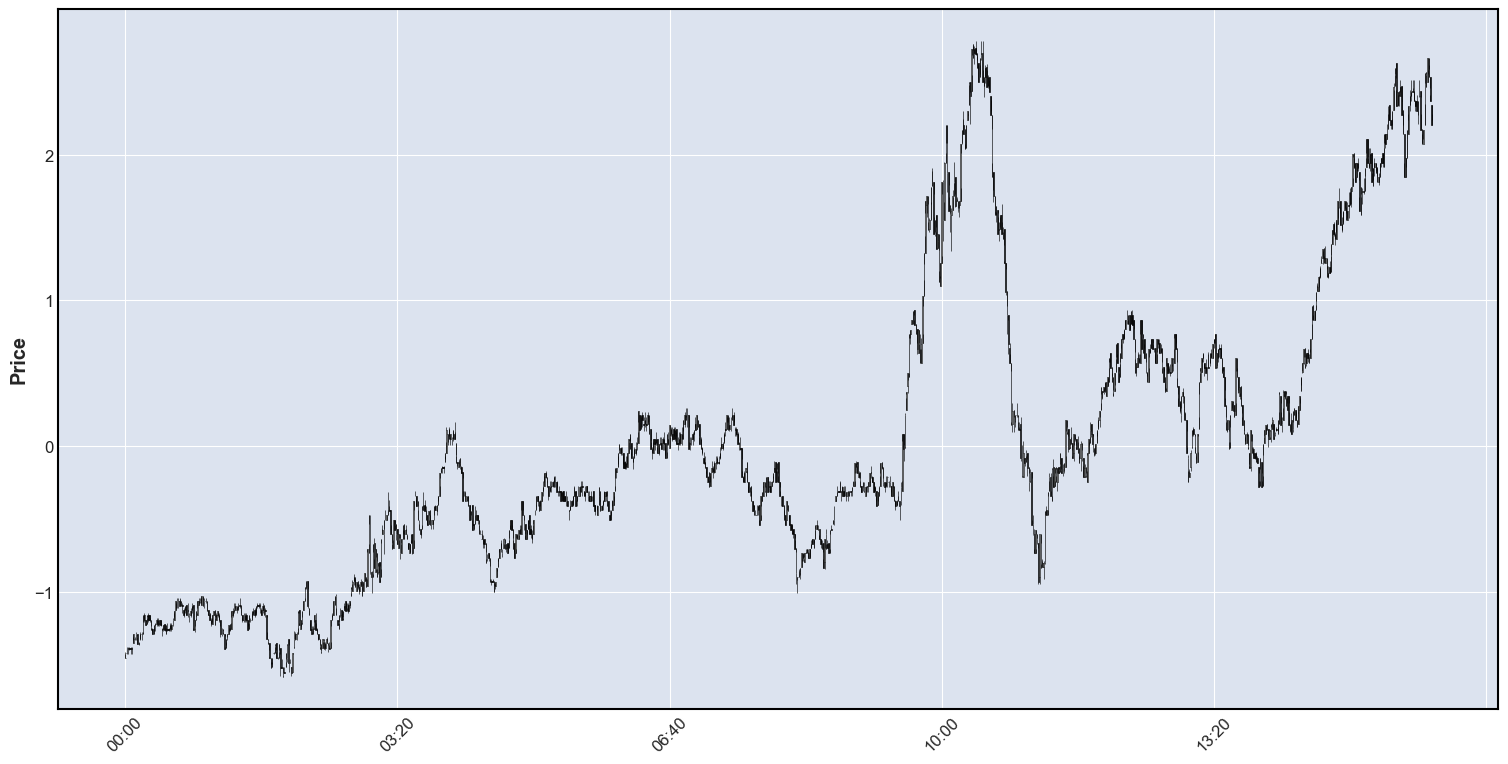

In [40]:
session_df = df.loc['2023-04-03'].between_time('0000', '1600')
past_normalized = (session_df - session_df.mean()) / session_df.std()
mpf.plot(past_normalized, figsize=(20,10), type='candle', warn_too_much_data=10000)

In [61]:
ranges = df.groupby([df.index.date]).close.agg(np.ptp)

<Axes: xlabel='close', ylabel='Count'>

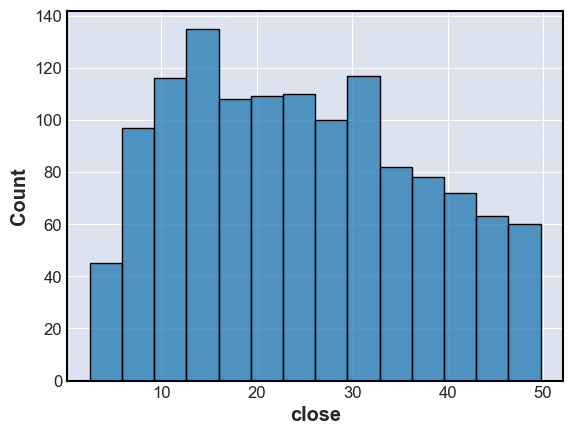

In [64]:
sns.histplot(ranges[ranges < 50])